In [1]:
"""
GraphSAINT for Product Categorization
ML4G Course Project - Applications Research with GNNs

Team: Abhishek Indupally, Pranav Bhimrao Kapadne, Gaurav Suvarna
Goal: Implement GraphSAINT as scalability model for large-scale GNN training
Dataset: ogbn-products with 15 selected product categories (excluding label 4)
GraphSAINT Strategies: Random Walk, Node Sampling, Edge Sampling
"""

'\nGraphSAINT for Product Categorization\nML4G Course Project - Applications Research with GNNs\n\nTeam: Abhishek Indupally, Pranav Bhimrao Kapadne, Gaurav Suvarna\nGoal: Implement GraphSAINT as scalability model for large-scale GNN training\nDataset: ogbn-products with 15 selected product categories (excluding label 4)\nGraphSAINT Strategies: Random Walk, Node Sampling, Edge Sampling\n'

============================================================
1. IMPORTS AND SETUP
============================================================

In [2]:
from ogb.nodeproppred import PygNodePropPredDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.serialization import add_safe_globals
from torch_geometric.data import Data, Batch
from torch_geometric.data.data import DataEdgeAttr, DataTensorAttr
from torch_geometric.data.storage import GlobalStorage, NodeStorage, EdgeStorage
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler, GraphSAINTEdgeSampler
from torch_geometric.utils import subgraph, degree
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All imports successful!
PyTorch version: 2.7.1+cu118
CUDA available: True


In [3]:
# Allowlist required torch_geometric classes for safe unpickling
add_safe_globals([DataEdgeAttr, DataTensorAttr, GlobalStorage, NodeStorage, EdgeStorage, Data, Batch])

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ===== LOAD BASELINE RESULTS FOR COMPARISON =====

mlp_results = None
gcn_results = None
sage_results = None
mlp_available = False
gcn_available = False
sage_available = False

# Try to load MLP results
if os.path.exists('mlp_500k_results.json'):
    try:
        with open('mlp_500k_results.json', 'r') as f:
            mlp_results = json.load(f)
        mlp_available = True
        print("✅ MLP baseline results loaded from mlp_500k_results.json")
        print(f"   MLP Test Accuracy: {mlp_results['test_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"⚠️  Could not load MLP results: {e}")
else:
    print("⚠️  mlp_500k_results.json not found")

# Try to load GCN results
if os.path.exists('gcn_results.json'):
    try:
        with open('gcn_results.json', 'r') as f:
            gcn_results = json.load(f)
        gcn_available = True
        print("✅ GCN baseline results loaded from gcn_results.json")
        print(f"   GCN Test Accuracy: {gcn_results['test_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"⚠️  Could not load GCN results: {e}")
else:
    print("⚠️  gcn_results.json not found")

# Try to load GraphSAGE results
if os.path.exists('GraphSage_results.json'):
    try:
        with open('GraphSage_results.json', 'r') as f:
            sage_results = json.load(f)
        sage_available = True
        print("✅ GraphSAGE baseline results loaded from GraphSage_results.json")
        print(f"   GraphSAGE Test Accuracy: {sage_results['test_accuracy']*100:.2f}%")
    except Exception as e:
        print(f"⚠️  Could not load GraphSAGE results: {e}")
else:
    print("⚠️  GraphSage_results.json not found")

print("\n" + "="*60)
available_models = []
if mlp_available:
    available_models.append('MLP')
if gcn_available:
    available_models.append('GCN')
if sage_available:
    available_models.append('GraphSAGE')

if available_models:
    print(f"✅ Ready to compare: {' vs '.join(available_models)} vs GraphSAINT")
else:
    print("⚠️  No baseline results found")
print("="*60)

✅ MLP baseline results loaded from mlp_500k_results.json
   MLP Test Accuracy: 61.92%
✅ GCN baseline results loaded from gcn_results.json
   GCN Test Accuracy: 76.68%
✅ GraphSAGE baseline results loaded from GraphSage_results.json
   GraphSAGE Test Accuracy: 76.09%

✅ Ready to compare: MLP vs GCN vs GraphSAGE vs GraphSAINT


## 2. Load Dataset and Graph Structure

Unlike MLP which only used node features, GraphSage will use the full graph structure (edges).

In [6]:
print("\nLoading ogbn-products dataset...")
dataset = PygNodePropPredDataset(name="ogbn-products", root="data")
data = dataset[0]

print("\n" + "="*60)
print("ORIGINAL DATASET INFO")
print("="*60)
print(f"Total nodes: {data.x.shape[0]:,}")
print(f"Node features: {data.x.shape[1]}")
print(f"Total edges: {data.edge_index.shape[1]:,}")
print(f"Labels shape: {data.y.shape}")
print(f"All unique labels: {torch.unique(data.y).numel()}")


Loading ogbn-products dataset...

ORIGINAL DATASET INFO
Total nodes: 2,449,029
Node features: 100
Total edges: 123,718,280
Labels shape: torch.Size([2449029, 1])
All unique labels: 47


## 2.5 Subsample for GPU Memory Constraints

**GPU Status:** 7.22 GiB free out of 11.90 GiB total

**Strategy:** Subsample to ~500K nodes to use ~5-6GB (safe buffer)

**Full dataset would require:** ~34GB (too large for available 7GB)

**Note:** This maximizes use of available GPU while maintaining stability.

In [7]:
print("\n" + "="*60)
print("SUBSAMPLING DATASET FOR GPU MEMORY")
print("="*60)

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Subsample to 500K nodes to use available 7GB GPU memory efficiently
subsample_size = 500000

# Random sample
total_nodes = data.x.shape[0]
sampled_indices = torch.randperm(total_nodes)[:subsample_size]
sampled_indices = sampled_indices.sort()[0]  # Sort for efficiency

print(f"Original dataset: {total_nodes:,} nodes")
print(f"Subsampled to: {len(sampled_indices):,} nodes")
print(f"Subsampling ratio: {100*len(sampled_indices)/total_nodes:.1f}%")
print(f"Target GPU usage: ~5-6GB out of 7.22GB available")

# Create mapping from old indices to new indices for this subsample
subsample_mapping = {}
for new_idx, old_idx in enumerate(sampled_indices):
    subsample_mapping[old_idx.item()] = new_idx

# Extract subgraph
print("\nExtracting subgraph...")
from torch_geometric.utils import subgraph as pyg_subgraph

subsampled_edge_index, _ = pyg_subgraph(
    subset=sampled_indices,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=total_nodes
)

# Update data object with subsampled data
data.x = data.x[sampled_indices]
data.y = data.y[sampled_indices]
data.edge_index = subsampled_edge_index

print(f"Edges after subsampling: {data.edge_index.shape[1]:,}")
print(f"Edge retention: {100*data.edge_index.shape[1]/123718280:.1f}%")
print("\n✅ Subsampling complete! Dataset optimized for 7GB available GPU memory.")
print("="*60)


SUBSAMPLING DATASET FOR GPU MEMORY
Original dataset: 2,449,029 nodes
Subsampled to: 500,000 nodes
Subsampling ratio: 20.4%
Target GPU usage: ~5-6GB out of 7.22GB available

Extracting subgraph...
Edges after subsampling: 5,167,660
Edge retention: 4.2%

✅ Subsampling complete! Dataset optimized for 7GB available GPU memory.


## 3. Load Sales Ranking Splits

Using the same splits as MLP baseline for fair comparison.

In [8]:
print("\n## 3. Load Sales Ranking Splits")
print("Using the same splits as other baselines for fair comparison.")

# Load custom splits from CSV files (sales_ranking strategy)
split_dir = "data/ogbn_products/split/sales_ranking/"
train_df = pd.read_csv(split_dir + "train.csv.gz")
valid_df = pd.read_csv(split_dir + "valid.csv.gz")
test_df = pd.read_csv(split_dir + "test.csv.gz")

# Get original split indices
original_train = torch.tensor(train_df.iloc[:, 0].values, dtype=torch.long)
original_valid = torch.tensor(valid_df.iloc[:, 0].values, dtype=torch.long)
original_test = torch.tensor(test_df.iloc[:, 0].values, dtype=torch.long)

print("\nOriginal split sizes (before subsampling):")
print(f"  Train: {len(original_train):,}")
print(f"  Valid: {len(original_valid):,}")
print(f"  Test: {len(original_test):,}")

# Filter splits to only include nodes in our subsample
train_in_sample = torch.isin(original_train, sampled_indices)
valid_in_sample = torch.isin(original_valid, sampled_indices)
test_in_sample = torch.isin(original_test, sampled_indices)

filtered_train_original = original_train[train_in_sample]
filtered_valid_original = original_valid[valid_in_sample]
filtered_test_original = original_test[test_in_sample]

print("\nSplit sizes after subsampling:")
print(f"  Train: {len(filtered_train_original):,}")
print(f"  Valid: {len(filtered_valid_original):,}")
print(f"  Test: {len(filtered_test_original):,}")

# Map original indices to new subsampled indices
split_idx = {
    'train': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_train_original]),
    'valid': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_valid_original]),
    'test': torch.tensor([subsample_mapping[idx.item()] for idx in filtered_test_original])
}

print("\n✅ Splits remapped to subsampled indices")


## 3. Load Sales Ranking Splits
Using the same splits as other baselines for fair comparison.

Original split sizes (before subsampling):
  Train: 196,614
  Valid: 39,322
  Test: 2,213,090

Split sizes after subsampling:
  Train: 40,255
  Valid: 8,078
  Test: 451,666

✅ Splits remapped to subsampled indices


## 4. Filter to Selected 15 Labels

Select labels 0-15 except 4 (removing the massive outlier with 668K samples).

In [9]:
print("\n## 4. Filter to Selected 15 Labels")
print("Select labels 0-15 except 4 (removing the massive outlier with 668K samples).")

# Select specific labels: 0-15 except 4
selected_labels = set(range(16)) - {4}  # {0,1,2,3,5,6,7,8,9,10,11,12,13,14,15}
print(f"Selected labels: {sorted(selected_labels)}")

# Filter nodes by selected labels (working with already subsampled data)
label_mask = torch.tensor([label.item() in selected_labels for label in data.y])
filtered_node_indices = torch.where(label_mask)[0]

print(f"\nFiltered nodes with selected labels: {filtered_node_indices.shape[0]:,}")
print(f"(After subsampling and label filtering)")

# Filter splits to only include selected labels
train_mask = torch.isin(split_idx['train'], filtered_node_indices)
valid_mask = torch.isin(split_idx['valid'], filtered_node_indices)
test_mask = torch.isin(split_idx['test'], filtered_node_indices)

filtered_train_idx = split_idx['train'][train_mask]
filtered_valid_idx = split_idx['valid'][valid_mask]
filtered_test_idx = split_idx['test'][test_mask]

print("\nFinal split sizes (subsampled + label filtered):")
print(f"  Train: {filtered_train_idx.shape[0]:,}")
print(f"  Valid: {filtered_valid_idx.shape[0]:,}")
print(f"  Test: {filtered_test_idx.shape[0]:,}")


## 4. Filter to Selected 15 Labels
Select labels 0-15 except 4 (removing the massive outlier with 668K samples).
Selected labels: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Filtered nodes with selected labels: 284,290
(After subsampling and label filtering)

Final split sizes (subsampled + label filtered):
  Train: 25,513
  Valid: 5,152
  Test: 253,624


## 5. Create Subgraph with Selected Labels

**Note:** Data is already subsampled (200K nodes). Now we filter further to only selected labels.

In [10]:
print("\n## 5. Create Subgraph with Selected Labels")

# Extract features and labels for filtered nodes
X = data.x[filtered_node_indices]
y = data.y[filtered_node_indices].squeeze()

# Remap labels to 0 to num_classes-1 (important for classification)
label_map = {orig: new for new, orig in enumerate(sorted(selected_labels))}
y_mapped = torch.tensor([label_map[label.item()] for label in y])

print(f"\nNode features shape: {X.shape}")
print(f"Labels shape: {y_mapped.shape}")
print(f"Unique labels in filtered set: {torch.unique(y).tolist()}")
print(f"Remapped labels: {torch.unique(y_mapped).tolist()}")

# Extract subgraph with selected nodes
print("\nExtracting subgraph with selected nodes and edges...")

# Use PyG's built-in subgraph function
remapped_edges, _ = subgraph(
    subset=filtered_node_indices,
    edge_index=data.edge_index,
    relabel_nodes=True,
    num_nodes=data.x.shape[0]
)

print(f"\n✅ Subgraph extraction complete!")
print(f"Original edges: {data.edge_index.shape[1]:,}")
print(f"Filtered edges: {remapped_edges.shape[1]:,}")
print(f"Percentage of edges kept: {100 * remapped_edges.shape[1] / data.edge_index.shape[1]:.2f}%")

# Create index mapping for remapping split indices
index_mapping = {orig_idx.item(): new_idx for new_idx, orig_idx in enumerate(filtered_node_indices)}
print(f"\n✅ Index mapping created for {len(index_mapping):,} nodes")

# Remap split indices to new filtered indices
train_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_train_idx])
valid_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_valid_idx])
test_idx = torch.tensor([index_mapping[idx.item()] for idx in filtered_test_idx])
print("\nRemapped split indices (for subgraph):")
print(f"  Train: {train_idx.shape[0]:,}")
print(f"  Valid: {valid_idx.shape[0]:,}")
print(f"  Test: {test_idx.shape[0]:,}")


## 5. Create Subgraph with Selected Labels

Node features shape: torch.Size([284290, 100])
Labels shape: torch.Size([284290])
Unique labels in filtered set: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Remapped labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

Extracting subgraph with selected nodes and edges...

✅ Subgraph extraction complete!
Original edges: 5,167,660
Filtered edges: 2,942,500
Percentage of edges kept: 56.94%

✅ Index mapping created for 284,290 nodes

Remapped split indices (for subgraph):
  Train: 25,513
  Valid: 5,152
  Test: 253,624


## 6. Analyze Graph Statistics

Understanding the graph structure is important for cold-start analysis later.

In [11]:
print("\n" + "="*60)
print("GRAPH STATISTICS (for Cold-Start Analysis)")
print("="*60)

# Compute node degrees
node_degrees = degree(remapped_edges[0], num_nodes=X.shape[0])

print(f"Nodes: {X.shape[0]:,}")
print(f"Edges: {remapped_edges.shape[1]:,}")
print(f"\nDegree Statistics:")
print(f"  Mean degree: {node_degrees.mean().item():.2f}")
print(f"  Median degree: {node_degrees.median().item():.2f}")
print(f"  Min degree: {node_degrees.min().item():.0f}")
print(f"  Max degree: {node_degrees.max().item():.0f}")
print(f"  Isolated nodes (degree=0): {(node_degrees == 0).sum().item():,}")
print(f"  Low-degree nodes (degree<10): {(node_degrees < 10).sum().item():,}")


GRAPH STATISTICS (for Cold-Start Analysis)
Nodes: 284,290
Edges: 2,942,500

Degree Statistics:
  Mean degree: 10.35
  Median degree: 5.00
  Min degree: 0
  Max degree: 1329
  Isolated nodes (degree=0): 37,531
  Low-degree nodes (degree<10): 187,206


## 7. Define GraphSAINT Model

**Architecture:** 2 SAGEConv layers with similar capacity to MLP baseline
- 128 hidden channels
- Dropout for regularization

In [12]:
class GraphSAINT(nn.Module):
    """GraphSAINT model using SAGEConv layers.
    
    Architecture matches GCN and GraphSAGE for fair comparison:
    - 2 SAGEConv layers
    - 128 hidden channels
    - Dropout for regularization
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GraphSAINT, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout
        
    def forward(self, x, edge_index):
        # First GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GraphSAGE layer
        x = self.conv2(x, edge_index)
        
        return x

# Model parameters
num_features = X.shape[1]
num_classes = len(selected_labels)
hidden_channels = 128

print("\n" + "="*60)
print("GraphSAINT ARCHITECTURE")
print("="*60)
print(f"Input features: {num_features}")
print(f"Hidden channels: {hidden_channels}")
print(f"Output classes: {num_classes}")
print(f"Dropout: 0.5")
print(f"\nModel: SAGEConv({num_features} → {hidden_channels}) → ReLU → Dropout → SAGEConv({hidden_channels} → {num_classes})")


GraphSAINT ARCHITECTURE
Input features: 100
Hidden channels: 128
Output classes: 15
Dropout: 0.5

Model: SAGEConv(100 → 128) → ReLU → Dropout → SAGEConv(128 → 15)


## 8. CREATE PYTORCH GEOMETRIC DATA OBJECT FOR GRAPHSAINT


In [13]:
print("\n## 8. Prepare Data for GraphSAINT (KEEP ON CPU)")

# IMPORTANT: Create PyG Data object on CPU for GraphSAINT
# GraphSAINT samplers require data to be on CPU
pyg_data_cpu = Data(
    x=X.cpu() if X.is_cuda else X,
    edge_index=remapped_edges.cpu() if remapped_edges.is_cuda else remapped_edges,
    y=y_mapped.cpu() if y_mapped.is_cuda else y_mapped
)

# Add train/val/test masks (on CPU)
pyg_data_cpu.train_mask = torch.zeros(X.shape[0], dtype=torch.bool)
pyg_data_cpu.val_mask = torch.zeros(X.shape[0], dtype=torch.bool)
pyg_data_cpu.test_mask = torch.zeros(X.shape[0], dtype=torch.bool)

pyg_data_cpu.train_mask[train_idx] = True
pyg_data_cpu.val_mask[valid_idx] = True
pyg_data_cpu.test_mask[test_idx] = True

# Verify everything is on CPU
print(f"✅ PyG Data object created (ON CPU)")
print(f"   Nodes: {pyg_data_cpu.num_nodes:,}")
print(f"   Edges: {pyg_data_cpu.num_edges:,}")
print(f"   Features: {pyg_data_cpu.num_node_features}")
print(f"   Train nodes: {pyg_data_cpu.train_mask.sum().item():,}")
print(f"   Val nodes: {pyg_data_cpu.val_mask.sum().item():,}")
print(f"   Test nodes: {pyg_data_cpu.test_mask.sum().item():,}")
print(f"\n🔍 Verification:")
print(f"   x on CUDA: {pyg_data_cpu.x.is_cuda} (should be False)")
print(f"   edge_index on CUDA: {pyg_data_cpu.edge_index.is_cuda} (should be False)")
print(f"   y on CUDA: {pyg_data_cpu.y.is_cuda} (should be False)")


## 8. Prepare Data for GraphSAINT (KEEP ON CPU)
✅ PyG Data object created (ON CPU)
   Nodes: 284,290
   Edges: 2,942,500
   Features: 100
   Train nodes: 25,513
   Val nodes: 5,152
   Test nodes: 253,624

🔍 Verification:
   x on CUDA: False (should be False)
   edge_index on CUDA: False (should be False)
   y on CUDA: False (should be False)


## 9. TRAINING FUNCTIONS


In [14]:
def train_epoch_graphsaint(model, loader, optimizer, device):
    """Train for one epoch using GraphSAINT sampling."""
    model.train()
    total_loss = 0
    total_correct = 0
    total_nodes = 0
    
    for batch_data in loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch_data.x, batch_data.edge_index)
        
        # Only compute loss on training nodes in this batch
        train_mask = batch_data.train_mask
        loss = F.cross_entropy(out[train_mask], batch_data.y[train_mask])
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item() * train_mask.sum().item()
        pred = out[train_mask].argmax(dim=1)
        total_correct += (pred == batch_data.y[train_mask]).sum().item()
        total_nodes += train_mask.sum().item()
    
    avg_loss = total_loss / total_nodes
    accuracy = total_correct / total_nodes
    return avg_loss, accuracy

@torch.no_grad()
def evaluate(model, data, mask, device):
    """Evaluate on full graph (no sampling)."""
    model.eval()
    data = data.to(device)
    
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[mask], data.y[mask])
    
    pred = out[mask].argmax(dim=1)
    accuracy = (pred == data.y[mask]).float().mean().item()
    
    return loss.item(), accuracy

@torch.no_grad()
def compute_topk_accuracy(model, data, mask, device, k_values=[1, 3, 5]):
    """Compute top-k accuracy."""
    model.eval()
    data = data.to(device)
    
    out = model(data.x, data.edge_index)
    logits = out[mask]
    targets = data.y[mask]
    
    topk_accs = []
    for k in k_values:
        _, topk_pred = torch.topk(logits, k, dim=1)
        correct = (topk_pred == targets.unsqueeze(1)).any(dim=1)
        topk_accs.append(correct.float().mean().item())
    
    return topk_accs

In [15]:
# ============================================================
# DIAGNOSTIC: Check where your data currently is
# ============================================================
# Run this cell FIRST to see if your data is on GPU

print("🔍 DIAGNOSTIC: Checking data location...")
print("="*60)

# Check if variables exist and where they are
if 'pyg_data_cpu' in locals() or 'pyg_data_cpu' in globals():
    print("\n📊 pyg_data_cpu object:")
    print(f"   x is on CUDA: {pyg_data_cpu.x.is_cuda}")
    print(f"   edge_index is on CUDA: {pyg_data_cpu.edge_index.is_cuda}")
    print(f"   y is on CUDA: {pyg_data_cpu.y.is_cuda}")
else:
    print("\n⚠️  pyg_data_cpu not found!")

if 'X' in locals() or 'X' in globals():
    print(f"\n📊 X tensor: is on CUDA: {X.is_cuda}")
else:
    print("\n⚠️  X not found!")

if 'remapped_edges' in locals() or 'remapped_edges' in globals():
    print(f"📊 remapped_edges tensor: is on CUDA: {remapped_edges.is_cuda}")
else:
    print("\n⚠️  remapped_edges not found!")

if 'y_mapped' in locals() or 'y_mapped' in globals():
    print(f"📊 y_mapped tensor: is on CUDA: {y_mapped.is_cuda}")
else:
    print("\n⚠️  y_mapped not found!")

print("\n" + "="*60)
print("💡 TIP: If ANY of these show 'True', that's your problem!")
print("    GraphSAINT requires ALL data to be on CPU (False)")
print("="*60)

🔍 DIAGNOSTIC: Checking data location...

📊 pyg_data_cpu object:
   x is on CUDA: False
   edge_index is on CUDA: False
   y is on CUDA: False

📊 X tensor: is on CUDA: False
📊 remapped_edges tensor: is on CUDA: False
📊 y_mapped tensor: is on CUDA: False

💡 TIP: If ANY of these show 'True', that's your problem!
    GraphSAINT requires ALL data to be on CPU (False)


## 10. TRAIN GRAPHSAINT WITH ALL THREE SAMPLING STRATEGIES


In [16]:
# ============================================================
# FIXED: TRAIN GRAPHSAINT WITH ALL THREE SAMPLING STRATEGIES
# ============================================================
# 
# KEY FIX: GraphSAINT samplers require data to be on CPU
# Data is moved to GPU batch-by-batch during training

print("\n## 9. Train GraphSAINT Models")

# SAMPLING_STRATEGIES = ['random_walk', 'node', 'edge']
SAMPLING_STRATEGIES = ['random_walk', 'node']
all_results = {}
all_histories = {}
all_models = {}

# IMPORTANT: Ensure pyg_data_cpu is on CPU for sampler creation
pyg_data_cpu = pyg_data_cpu.cpu()  # Make sure data is on CPU

for sampling_strategy in SAMPLING_STRATEGIES:
    print(f"\n{'='*70}")
    print(f"Training GraphSAINT with {sampling_strategy.upper()} sampling")
    print(f"{'='*70}\n")

    iteration_data_cpu = pyg_data_cpu.clone()  
    
    # Create sampler (data must be on CPU)
    if sampling_strategy == 'random_walk':
        print("Using Random Walk Sampling")
        train_loader = GraphSAINTRandomWalkSampler(
            iteration_data_cpu,  # Use CPU version
            batch_size=6000,
            walk_length=2,
            num_steps=30,
            sample_coverage=100,
            save_dir=None
        )
    elif sampling_strategy == 'node':
        print("Using Node Sampling")
        train_loader = GraphSAINTNodeSampler(
            iteration_data_cpu,  # Use CPU version
            batch_size=6000,
            num_steps=30,
            sample_coverage=100,
            save_dir=None
        )
    # elif sampling_strategy == 'edge':
    #     print("Using Edge Sampling")
    #     train_loader = GraphSAINTEdgeSampler(
    #         iteration_data_cpu,  # Use CPU version
    #         batch_size=1000,
    #         num_steps=30,
    #         sample_coverage=100,
    #         save_dir=None
    #     )
    
    # Initialize model
    model = GraphSAINT(
        in_channels=num_features,
        hidden_channels=hidden_channels,
        out_channels=num_classes,
        dropout=0.5
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    best_val_acc = 0
    best_epoch = 0
    patience_counter = 0
    patience = 50
    epochs = 400
    
    start_time = time.time()
    
    for epoch in range(1, epochs + 1):
        # Train (data moved to GPU batch-by-batch in train_epoch_graphsaint)
        train_loss, train_acc = train_epoch_graphsaint(model, train_loader, optimizer, device)
        
        # Evaluate (use CPU version, it will be moved to GPU in evaluate function)
        val_loss, val_acc = evaluate(model, iteration_data_cpu, iteration_data_cpu.val_mask, device)
        test_loss, test_acc = evaluate(model, iteration_data_cpu, iteration_data_cpu.test_mask, device)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
                  f"Test Acc: {test_acc:.4f}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch} (no improvement for {patience} epochs)")
            break
    
    training_time = time.time() - start_time
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Final evaluation (use CPU version)
    final_data = pyg_data_cpu.clone()
    _, train_acc = evaluate(model, final_data, final_data.train_mask, device)
    _, val_acc = evaluate(model, final_data, final_data.val_mask, device)
    _, test_acc = evaluate(model, final_data, final_data.test_mask, device)
    
    # Compute top-k accuracy (use CPU version)
    topk_accs = compute_topk_accuracy(model, final_data, final_data.test_mask, device)
    
    print(f"\n{'='*70}")
    print(f"Best model at epoch {best_epoch}:")
    print(f"  Train Acc: {train_acc:.4f}")
    print(f"  Val Acc:   {val_acc:.4f}")
    print(f"  Test Acc:  {test_acc:.4f}")
    print(f"  Top-1 Acc: {topk_accs[0]:.4f}")
    print(f"  Top-3 Acc: {topk_accs[1]:.4f}")
    print(f"  Top-5 Acc: {topk_accs[2]:.4f}")
    print(f"  Training time: {training_time:.2f}s")
    print(f"{'='*70}\n")
    
    # Store results
    results = {
        'model': f'GraphSAINT_{sampling_strategy}',
        'sampling_strategy': sampling_strategy,
        'test_accuracy': test_acc,
        'val_accuracy': val_acc,
        'train_accuracy': train_acc,
        'best_epoch': best_epoch,
        'training_time': training_time,
        'num_parameters': sum(p.numel() for p in model.parameters()),
        'top1_acc': topk_accs[0],
        'top3_acc': topk_accs[1],
        'top5_acc': topk_accs[2],
        'hidden_channels': hidden_channels,
        'num_classes': num_classes,
        'num_nodes': X.shape[0],
        'num_edges': remapped_edges.shape[1],
        'random_seed': 42
    }
    
    all_results[sampling_strategy] = results
    all_histories[sampling_strategy] = history
    all_models[sampling_strategy] = model
    
    # Save individual results
    with open(f'graphsaint_{sampling_strategy}_results.json', 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✅ Results saved to graphsaint_{sampling_strategy}_results.json\n")

print("\n✅ All two sampling strategies trained successfully!")


## 9. Train GraphSAINT Models

Training GraphSAINT with RANDOM_WALK sampling

Using Random Walk Sampling


Compute GraphSAINT normalization: : 28832812it [00:14, 2042042.62it/s]                            


Epoch   1 | Train Loss: 1.0206, Acc: 0.7276 | Val Loss: 0.6328, Acc: 0.8309 | Test Acc: 0.7417
Epoch  10 | Train Loss: 0.4284, Acc: 0.8797 | Val Loss: 0.4813, Acc: 0.8758 | Test Acc: 0.7756
Epoch  20 | Train Loss: 0.4133, Acc: 0.8831 | Val Loss: 0.4924, Acc: 0.8804 | Test Acc: 0.7764
Epoch  30 | Train Loss: 0.4128, Acc: 0.8890 | Val Loss: 0.4951, Acc: 0.8773 | Test Acc: 0.7785
Epoch  40 | Train Loss: 0.4043, Acc: 0.8893 | Val Loss: 0.5148, Acc: 0.8769 | Test Acc: 0.7813
Epoch  50 | Train Loss: 0.3964, Acc: 0.8928 | Val Loss: 0.5233, Acc: 0.8777 | Test Acc: 0.7796
Epoch  60 | Train Loss: 0.3901, Acc: 0.8922 | Val Loss: 0.5307, Acc: 0.8781 | Test Acc: 0.7845
Epoch  70 | Train Loss: 0.3820, Acc: 0.8928 | Val Loss: 0.5393, Acc: 0.8758 | Test Acc: 0.7781
Epoch  80 | Train Loss: 0.3808, Acc: 0.8944 | Val Loss: 0.5474, Acc: 0.8797 | Test Acc: 0.7713
Epoch  90 | Train Loss: 0.3822, Acc: 0.8937 | Val Loss: 0.5545, Acc: 0.8764 | Test Acc: 0.7790

Early stopping at epoch 93 (no improvement for 50

Compute GraphSAINT normalization: : 28520381it [00:14, 1959398.12it/s]                            


Epoch   1 | Train Loss: 1.1385, Acc: 0.6888 | Val Loss: 0.7451, Acc: 0.8080 | Test Acc: 0.7160
Epoch  10 | Train Loss: 0.5918, Acc: 0.8353 | Val Loss: 0.6448, Acc: 0.8424 | Test Acc: 0.7563
Epoch  20 | Train Loss: 0.6049, Acc: 0.8378 | Val Loss: 0.6535, Acc: 0.8422 | Test Acc: 0.7587
Epoch  30 | Train Loss: 0.5733, Acc: 0.8417 | Val Loss: 0.6449, Acc: 0.8459 | Test Acc: 0.7757
Epoch  40 | Train Loss: 0.5651, Acc: 0.8431 | Val Loss: 0.6390, Acc: 0.8490 | Test Acc: 0.7701
Epoch  50 | Train Loss: 0.5608, Acc: 0.8466 | Val Loss: 0.6635, Acc: 0.8533 | Test Acc: 0.7598
Epoch  60 | Train Loss: 0.5430, Acc: 0.8512 | Val Loss: 0.6422, Acc: 0.8467 | Test Acc: 0.7574
Epoch  70 | Train Loss: 0.5537, Acc: 0.8472 | Val Loss: 0.6767, Acc: 0.8500 | Test Acc: 0.7528
Epoch  80 | Train Loss: 0.5400, Acc: 0.8501 | Val Loss: 0.6728, Acc: 0.8496 | Test Acc: 0.7641

Early stopping at epoch 86 (no improvement for 50 epochs)

Best model at epoch 36:
  Train Acc: 0.8890
  Val Acc:   0.8455
  Test Acc:  0.7641
 

## 11. SELECT BEST STRATEGY AND COMPARE WITH BASELINES


In [17]:
print("\n" + "="*70)
print("COMPARISON OF SAMPLING STRATEGIES")
print("="*70)

for strategy in SAMPLING_STRATEGIES:
    results = all_results[strategy]
    print(f"\n{strategy.upper()} Sampling:")
    print(f"  Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"  Val Accuracy:  {results['val_accuracy']:.4f}")
    print(f"  Top-3 Accuracy: {results['top3_acc']:.4f}")
    print(f"  Training Time: {results['training_time']:.2f}s")
    print(f"  Best Epoch:    {results['best_epoch']}")

# Select best based on validation accuracy
best_strategy = max(all_results.items(), key=lambda x: x[1]['val_accuracy'])[0]
print(f"\n{'='*70}")
print(f"BEST STRATEGY: {best_strategy.upper()} (Val Acc: {all_results[best_strategy]['val_accuracy']:.4f})")
print(f"{'='*70}\n")

best_results = all_results[best_strategy]
best_history = all_histories[best_strategy]
best_model = all_models[best_strategy]

# Add baseline comparisons
if mlp_available:
    best_results['mlp_baseline'] = mlp_results['test_accuracy']
    best_results['improvement_over_mlp'] = best_results['test_accuracy'] - mlp_results['test_accuracy']
    best_results['improvement_over_mlp_pct'] = (best_results['improvement_over_mlp'] / mlp_results['test_accuracy']) * 100

if gcn_available:
    best_results['gcn_baseline'] = gcn_results['test_accuracy']
    best_results['improvement_over_gcn'] = best_results['test_accuracy'] - gcn_results['test_accuracy']
    best_results['improvement_over_gcn_pct'] = (best_results['improvement_over_gcn'] / gcn_results['test_accuracy']) * 100

if sage_available:
    best_results['graphsage_baseline'] = sage_results['test_accuracy']
    best_results['improvement_over_sage'] = best_results['test_accuracy'] - sage_results['test_accuracy']
    best_results['improvement_over_sage_pct'] = (best_results['improvement_over_sage'] / sage_results['test_accuracy']) * 100

# Save best results
with open('graphsaint_best_results.json', 'w') as f:
    json.dump(best_results, f, indent=2)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)


COMPARISON OF SAMPLING STRATEGIES

RANDOM_WALK Sampling:
  Test Accuracy: 0.7715
  Val Accuracy:  0.8791
  Top-3 Accuracy: 0.9169
  Training Time: 53.00s
  Best Epoch:    43

NODE Sampling:
  Test Accuracy: 0.7641
  Val Accuracy:  0.8455
  Top-3 Accuracy: 0.9223
  Training Time: 29.52s
  Best Epoch:    36

BEST STRATEGY: RANDOM_WALK (Val Acc: 0.8791)


MODEL COMPARISON


In [18]:
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

if mlp_available:
    mlp_acc = mlp_results['test_accuracy']
    print(f"\nMLP Baseline:        {mlp_acc:.4f}")

if gcn_available:
    gcn_acc = gcn_results['test_accuracy']
    print(f"GCN:                 {gcn_acc:.4f} (+{(gcn_acc-mlp_acc)/mlp_acc*100:.2f}% vs MLP)" if mlp_available else f"GCN:                 {gcn_acc:.4f}")

if sage_available:
    sage_acc = sage_results['test_accuracy']
    print(f"GraphSAGE:           {sage_acc:.4f} (+{(sage_acc-mlp_acc)/mlp_acc*100:.2f}% vs MLP)" if mlp_available else f"GraphSAGE:           {sage_acc:.4f}")

print(f"GraphSAINT ({best_strategy}): {best_results['test_accuracy']:.4f} ", end='')
if mlp_available:
    print(f"(+{best_results['improvement_over_mlp_pct']:.2f}% vs MLP)")
else:
    print()

if gcn_available:
    print(f"\nGraphSAINT vs GCN:       {best_results['improvement_over_gcn']:+.4f} ({best_results['improvement_over_gcn_pct']:+.2f}%)")
if sage_available:
    print(f"GraphSAINT vs GraphSAGE: {best_results['improvement_over_sage']:+.4f} ({best_results['improvement_over_sage_pct']:+.2f}%)")

print("="*70 + "\n")


MODEL COMPARISON

MLP Baseline:        0.6192
GCN:                 0.7668 (+23.83% vs MLP)
GraphSAGE:           0.7609 (+22.87% vs MLP)
GraphSAINT (random_walk): 0.7715 (+24.60% vs MLP)

GraphSAINT vs GCN:       +0.0047 (+0.62%)
GraphSAINT vs GraphSAGE: +0.0107 (+1.40%)



============================================================
14. CREATE VISUALIZATIONS
============================================================


## 10. Create Visualizations


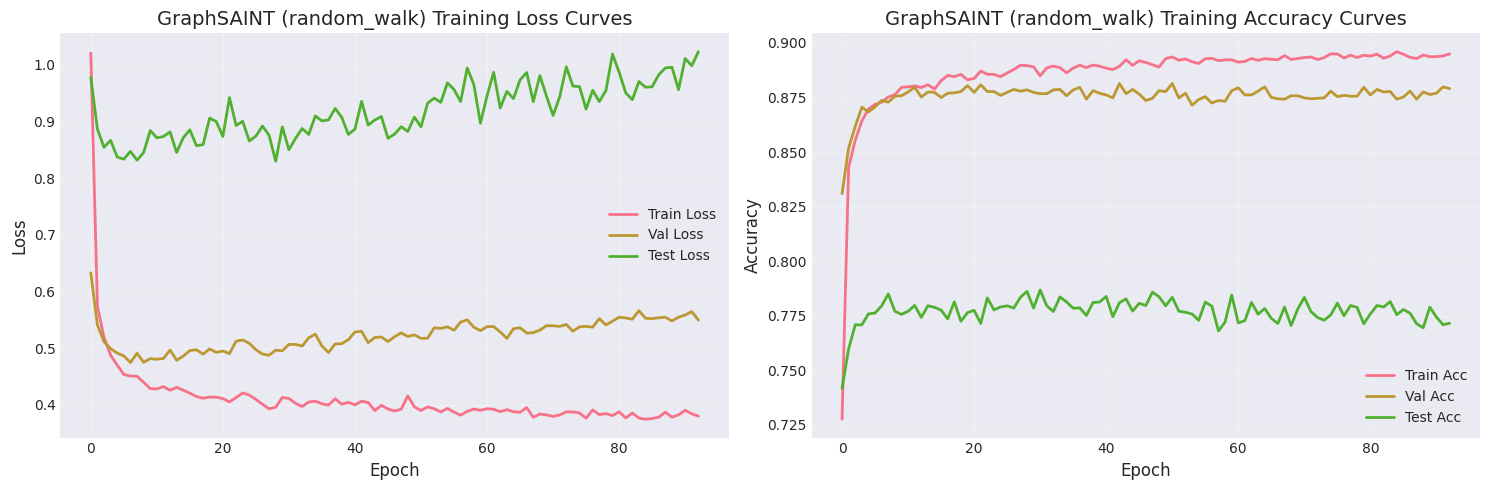

✅ Saved: graphsaint_training_curves.png


In [19]:
print("\n## 10. Create Visualizations")
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Plot 1: Training curves for best strategy
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(best_history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(best_history['val_loss'], label='Val Loss', linewidth=2)
axes[0].plot(best_history['test_loss'], label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title(f'GraphSAINT ({best_strategy}) Training Loss Curves', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(best_history['train_acc'], label='Train Acc', linewidth=2)
axes[1].plot(best_history['val_acc'], label='Val Acc', linewidth=2)
axes[1].plot(best_history['test_acc'], label='Test Acc', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title(f'GraphSAINT ({best_strategy}) Training Accuracy Curves', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('images/graphsaint/graphsaint_training_curves.png', dpi=300, bbox_inches='tight')
print("✅ Saved: graphsaint_training_curves.png")
plt.close()

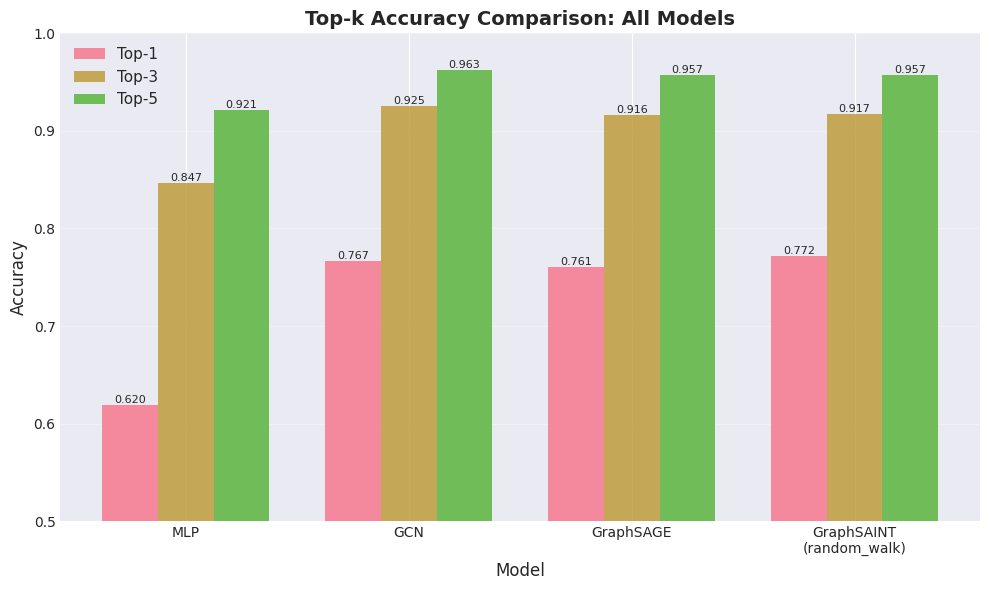

✅ Saved: graphsaint_topk_comparison.png


In [20]:
# Plot 2: Top-k accuracy comparison (if baselines available)
if mlp_available or gcn_available or sage_available:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    models = []
    top1_accs = []
    top3_accs = []
    top5_accs = []
    
    if mlp_available:
        models.append('MLP')
        top1_accs.append(mlp_results.get('top1_acc', mlp_results['test_accuracy']))
        top3_accs.append(mlp_results.get('top3_acc', 0.85))
        top5_accs.append(mlp_results.get('top5_acc', 0.92))
    
    if gcn_available:
        models.append('GCN')
        top1_accs.append(gcn_results.get('top1_acc', gcn_results['test_accuracy']))
        top3_accs.append(gcn_results.get('top3_acc', 0.93))
        top5_accs.append(gcn_results.get('top5_acc', 0.96))
    
    if sage_available:
        models.append('GraphSAGE')
        top1_accs.append(sage_results.get('top1_acc', sage_results['test_accuracy']))
        top3_accs.append(sage_results.get('top3_acc', 0.92))
        top5_accs.append(sage_results.get('top5_acc', 0.96))
    
    models.append(f'GraphSAINT\n({best_strategy})')
    top1_accs.append(best_results['top1_acc'])
    top3_accs.append(best_results['top3_acc'])
    top5_accs.append(best_results['top5_acc'])
    
    x = np.arange(len(models))
    width = 0.25
    
    bars1 = ax.bar(x - width, top1_accs, width, label='Top-1', alpha=0.8)
    bars2 = ax.bar(x, top3_accs, width, label='Top-3', alpha=0.8)
    bars3 = ax.bar(x + width, top5_accs, width, label='Top-5', alpha=0.8)
    
    ax.set_xlabel('Model', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Top-k Accuracy Comparison: All Models', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.5, 1.0])
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}',
                    ha='center', va='bottom', fontsize=8)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    plt.tight_layout()
    plt.show()
    plt.savefig('images/graphsaint/graphsaint_topk_comparison.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: graphsaint_topk_comparison.png")
    plt.close()

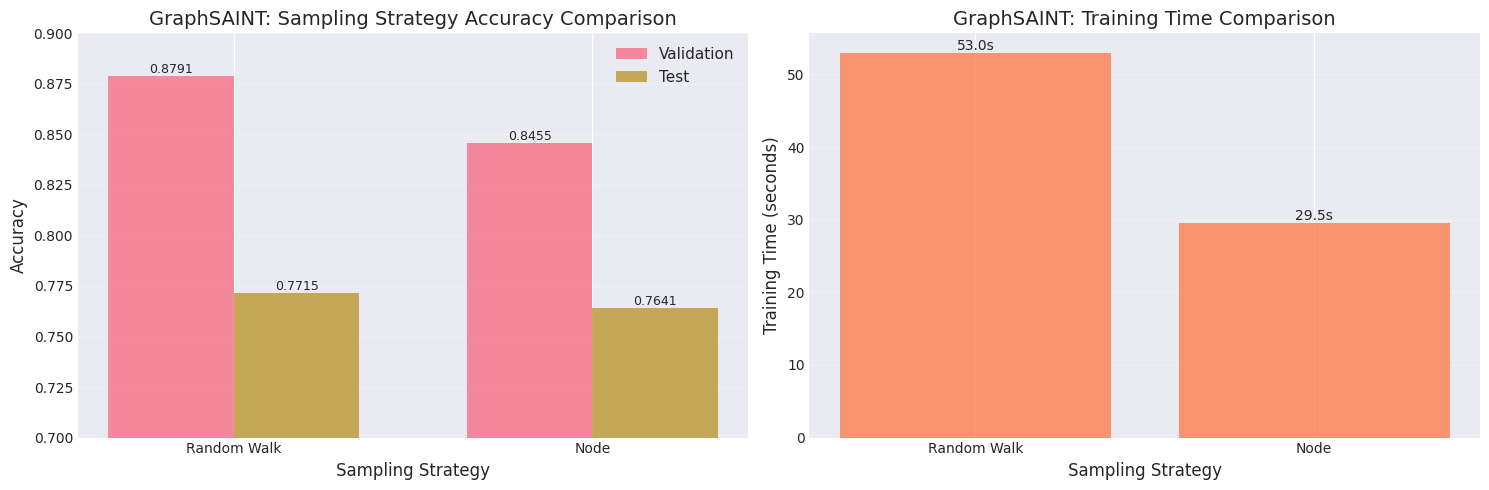

✅ Saved: graphsaint_sampling_comparison.png


In [21]:
# Plot 3: Sampling strategy comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

strategies = [s.replace('_', ' ').title() for s in SAMPLING_STRATEGIES]
test_accs = [all_results[s]['test_accuracy'] for s in SAMPLING_STRATEGIES]
val_accs = [all_results[s]['val_accuracy'] for s in SAMPLING_STRATEGIES]
train_times = [all_results[s]['training_time'] for s in SAMPLING_STRATEGIES]

# Accuracy comparison
x = np.arange(len(strategies))
width = 0.35

bars1 = axes[0].bar(x - width/2, val_accs, width, label='Validation', alpha=0.8)
bars2 = axes[0].bar(x + width/2, test_accs, width, label='Test', alpha=0.8)

axes[0].set_xlabel('Sampling Strategy', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('GraphSAINT: Sampling Strategy Accuracy Comparison', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(strategies)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.7, 0.9])

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=9)

# Training time comparison
bars = axes[1].bar(strategies, train_times, alpha=0.8, color='coral')
axes[1].set_xlabel('Sampling Strategy', fontsize=12)
axes[1].set_ylabel('Training Time (seconds)', fontsize=12)
axes[1].set_title('GraphSAINT: Training Time Comparison', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}s',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
plt.savefig('images/graphsaint/graphsaint_sampling_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: graphsaint_sampling_comparison.png")
plt.close()

In [22]:
# Plot 4: Confusion Matrix
@torch.no_grad()
def compute_confusion_matrix(model, data, mask, device):
    """Compute confusion matrix."""
    model.eval()
    data = data.to(device)
    
    out = model(data.x, data.edge_index)
    pred = out[mask].argmax(dim=1)
    targets = data.y[mask]
    
    # Compute confusion matrix
    num_classes = out.shape[1]
    conf_matrix = torch.zeros(num_classes, num_classes)
    
    for t, p in zip(targets, pred):
        conf_matrix[t, p] += 1
    
    return conf_matrix.cpu().numpy()

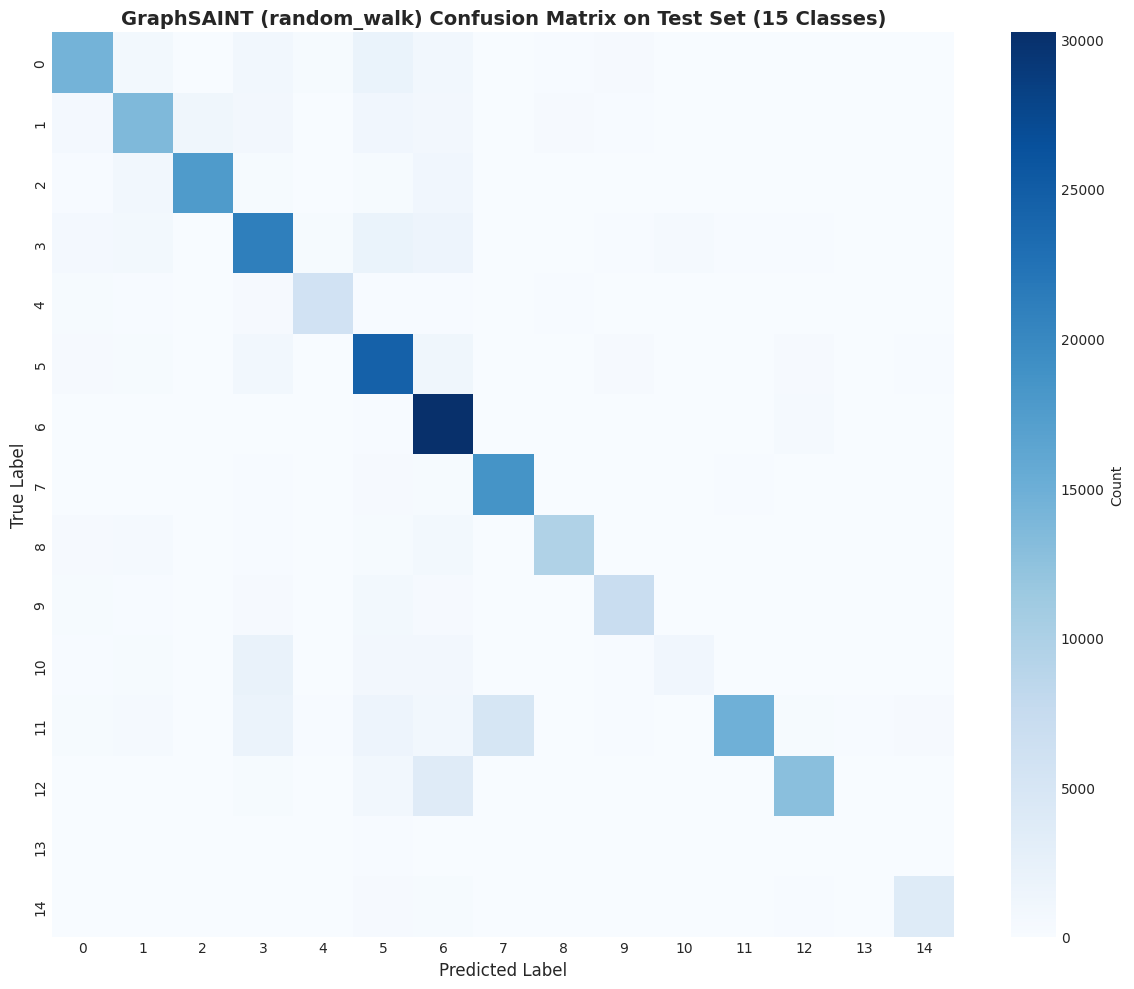

✅ Saved: graphsaint_confusion_matrix.png


In [23]:
conf_matrix = compute_confusion_matrix(best_model, pyg_data_cpu, pyg_data_cpu.test_mask, device)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='g', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title(f'GraphSAINT ({best_strategy}) Confusion Matrix on Test Set ({num_classes} Classes)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
plt.savefig('images/graphsaint/graphsaint_confusion_matrix.png', dpi=300, bbox_inches='tight')
print("✅ Saved: graphsaint_confusion_matrix.png")
plt.close()

============================================================
15. FINAL SUMMARY
============================================================

In [24]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print(f"\n📊 DATASET:")
print(f"  Total products: {X.shape[0]:,}")
print(f"  Categories: {num_classes}")
print(f"  Co-purchase edges: {remapped_edges.shape[1]:,}")
print(f"  Test set size: {test_idx.shape[0]:,}")

print(f"\n🎯 GRAPHSAINT PERFORMANCE ({best_strategy.upper()} sampling):")
print(f"  Test Accuracy:  {best_results['test_accuracy']:.4f}")
print(f"  Top-3 Accuracy: {best_results['top3_acc']:.4f}")
print(f"  Top-5 Accuracy: {best_results['top5_acc']:.4f}")
print(f"  Training Time:  {best_results['training_time']:.2f}s")
print(f"  Best Epoch:     {best_results['best_epoch']}")

print(f"\n⏱️  COMPUTATIONAL COST:")
print(f"  Training time: {best_results['training_time']:.2f}s ({best_results['training_time']/60:.2f} min)")
print(f"  Time per epoch: {best_results['training_time']/best_results['best_epoch']:.2f}s")

print(f"\n📈 MODEL COMPARISON:")
if mlp_available:
    print(f"  MLP:       {mlp_results['test_accuracy']:.4f}")
if gcn_available:
    print(f"  GCN:       {gcn_results['test_accuracy']:.4f}")
if sage_available:
    print(f"  GraphSAGE: {sage_results['test_accuracy']:.4f}")
print(f"  GraphSAINT: {best_results['test_accuracy']:.4f} ⭐")

print(f"\n📁 GENERATED FILES:")
print(f"  - graphsaint_best_results.json")
for strategy in SAMPLING_STRATEGIES:
    print(f"  - graphsaint_{strategy}_results.json")
print(f"  - graphsaint_training_curves.png")
print(f"  - graphsaint_topk_comparison.png")
print(f"  - graphsaint_sampling_comparison.png")
print(f"  - graphsaint_confusion_matrix.png")


FINAL RESULTS SUMMARY

📊 DATASET:
  Total products: 284,290
  Categories: 15
  Co-purchase edges: 2,942,500
  Test set size: 253,624

🎯 GRAPHSAINT PERFORMANCE (RANDOM_WALK sampling):
  Test Accuracy:  0.7715
  Top-3 Accuracy: 0.9169
  Top-5 Accuracy: 0.9572
  Training Time:  53.00s
  Best Epoch:     43

⏱️  COMPUTATIONAL COST:
  Training time: 53.00s (0.88 min)
  Time per epoch: 1.23s

📈 MODEL COMPARISON:
  MLP:       0.6192
  GCN:       0.7668
  GraphSAGE: 0.7609
  GraphSAINT: 0.7715 ⭐

📁 GENERATED FILES:
  - graphsaint_best_results.json
  - graphsaint_random_walk_results.json
  - graphsaint_node_results.json
  - graphsaint_training_curves.png
  - graphsaint_topk_comparison.png
  - graphsaint_sampling_comparison.png
  - graphsaint_confusion_matrix.png


In [25]:
print(all_models)

{'random_walk': GraphSAINT(
  (conv1): SAGEConv(100, 128, aggr=mean)
  (conv2): SAGEConv(128, 15, aggr=mean)
), 'node': GraphSAINT(
  (conv1): SAGEConv(100, 128, aggr=mean)
  (conv2): SAGEConv(128, 15, aggr=mean)
)}


In [26]:
os.makedirs('models', exist_ok=True)

# Save both GraphSAINT models (assuming you have all_models dict)
# If you stored models differently, adjust the variable names

# Save Random Walk model
torch.save(all_models['random_walk'].state_dict(), 'models/graphsaint_rw_best.pt')
print("✅ Saved GraphSAINT-RW model to models/graphsaint_rw_best.pt")

# Save Node sampling model
torch.save(all_models['node'].state_dict(), 'models/graphsaint_node_best.pt')
print("✅ Saved GraphSAINT-Node model to models/graphsaint_node_best.pt")

print(f"\n✅ Total saved:")
print(f"   RW file size: {os.path.getsize('models/graphsaint_rw_best.pt') / (1024*1024):.2f} MB")
print(f"   Node file size: {os.path.getsize('models/graphsaint_node_best.pt') / (1024*1024):.2f} MB")

✅ Saved GraphSAINT-RW model to models/graphsaint_rw_best.pt
✅ Saved GraphSAINT-Node model to models/graphsaint_node_best.pt

✅ Total saved:
   RW file size: 0.12 MB
   Node file size: 0.12 MB
